In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf
import matplotlib.dates as mdates
# Import
from sklearn.preprocessing import MinMaxScaler 


# Configuración de la política de precisión mixta
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

df_ep = pd.read_csv("csv/Electric_Production.csv")

def data_converter(eingang):
    DD = eingang[:-7]  # Extract the first two characters (day)
    MM = eingang[-6:-5]  # Extract the next two characters (month)
    YYYY = eingang[-4:]  # Extract the remaining characters (year)
    out = (f'{YYYY}/{MM}/{DD}')
    return out

    #out = dt.datetime.strptime(eingang, )
    #date_format = '%YYYY/%MM%/%DD'


df_ep['DATE'] = df_ep['DATE'].apply(data_converter)

df_ep = df_ep[['DATE','IPG2211A2N']] # Columnas con las que vamos a trabajar.

df_ep = df_ep.sort_values("DATE") # Ordenando el dataset en funcion de las fechas

df_ep = df_ep.set_index("DATE") # 


# Split into train, validation, and test sets
train_size = int(len(df_ep) * 0.5)
validation_size = int(len(df_ep) * 0.25)

# 50% train_Set
train_Set = df_ep.iloc[0:train_size, :]

# 25% validation_Set
validation_Set = df_ep.iloc[train_size:train_size + validation_size, :] 

# 25% test_Set
test_Set = df_ep.iloc[train_size + validation_size:len(df_ep), :] 

# Fit scaler
scaler = MinMaxScaler()
scaler.fit(train_Set)

# Escalado de los diferentes conjuntos:
train = pd.DataFrame(scaler.transform(train_Set), columns=['Adj Close'], index=train_Set.index)
validation = pd.DataFrame(scaler.transform(validation_Set), columns=['Adj Close'], index=validation_Set.index)
test = pd.DataFrame(scaler.transform(test_Set), columns=['Adj Close'], index=test_Set.index)

# Define a helper function to construct windowed datasets
def create_dataset(dataset, window_size ):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        window = dataset.iloc[i:(i + window_size), 0]
        target = dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [2]:
diccionario = dict()

from tensorflow import keras
from tensorflow.keras import layers
# Import
from sklearn.metrics import r2_score

counter = -2
for loop in range(1,45,5):
    # Set the desired window size
    window_size = loop

    # Construct train, validation, and test datasets
    X_train, y_train = create_dataset(train, window_size)
    X_validation, y_validation = create_dataset(validation, window_size)
    X_test, y_test = create_dataset(test, window_size)

    # Reshape into NumPy arrays
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    counter+=1
    for innerloop in range(100, 325, 25):
        # Build the model
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv1D(64, 1, activation="relu", input_shape=(1, window_size)))
        model.add(tf.keras.layers.MaxPooling1D(1))
        model.add(tf.keras.layers.LSTM(
            64,
            input_shape=(1,window_size),
            activation='tanh', # activation='tanh',
            recurrent_activation='sigmoid',
            use_bias=True,
            kernel_initializer='glorot_uniform',
            recurrent_initializer='orthogonal',
            bias_initializer='zeros',
            unit_forget_bias=True,
            kernel_regularizer=None,
            recurrent_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            recurrent_constraint=None,
            bias_constraint=None,
            dropout=0.0,
            recurrent_dropout=0.0,
            return_sequences=False,
            return_state=False,
            go_backwards=False,
            stateful=False,
            time_major=False,
            unroll=False,
        ))
        #model.add(tf.keras.layers.LSTM(64, activation='relu'))
        model.add(tf.keras.layers.Dense(32, activation='relu'))
        model.add(tf.keras.layers.Dense(16, activation='relu'))
        model.add(tf.keras.layers.Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.summary()

        # Train the model
        model.fit(X_train, y_train, epochs=innerloop,verbose=1)

        # Make predictions and evaluate
        y_pred = model.predict(X_validation)
        print(f"\nR-Squared value on validation set: {r2_score(y_validation, y_pred)}")
        
        score = r2_score(y_validation, y_pred)
        
        diccionario[(loop,innerloop)]=score
        
diccionario 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 64)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                        

7/7 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 89/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 90/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 91/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 92/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 93/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 94/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 95/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 96/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 97/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 98/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 99/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 100/100
4/4 [==============================] - 0s 9ms/step


Epoch 74/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 75/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0233
Epoch 76/125
7/7 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 77/125
7/7 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 78/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 79/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 80/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 81/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 82/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 83/125
7/7 [==============================] - 0s 5ms/step - loss: 0.0223
Epoch 84/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 85/125
7/7 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 86/125
7/7 [==============================] - 

7/7 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 35/150
7/7 [==============================] - 0s 5ms/step - loss: 0.0237
Epoch 36/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 37/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0240
Epoch 38/150
7/7 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 39/150
7/7 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 40/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 41/150
7/7 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 42/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 43/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 44/150
7/7 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 45/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 46/150
7/7 [==============================] - 0s 4ms/step -

7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 138/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 139/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 140/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 141/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 142/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 143/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0216
Epoch 144/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 145/150
7/7 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 146/150
7/7 [==============================] - 0s 6ms/step - loss: 0.0219
Epoch 147/150
7/7 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 148/150
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 149/150
7/7 [==============================] - 0

7/7 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 73/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 74/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 75/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0233
Epoch 76/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0232
Epoch 77/175
7/7 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 78/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 79/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0238
Epoch 80/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0232
Epoch 81/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 82/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 83/175
7/7 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 84/175
7/7 [==============================] - 0s 5ms/step -

7/7 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 175/175
4/4 [==============================] - 0s 1ms/step

R-Squared value on validation set: -0.8763326632874031
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 1, 64)             128       
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       

Epoch 85/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 86/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 87/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0233
Epoch 88/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 89/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 90/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 91/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0228
Epoch 92/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 93/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 94/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 95/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 96/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 97/200
7/7 [==============================] - 

7/7 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 188/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 189/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 190/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 191/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 192/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 193/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 194/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 195/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 196/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 197/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 198/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 199/200
7/7 [==============================] - 0

7/7 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 73/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0232
Epoch 74/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 75/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 76/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 77/225
7/7 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 78/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 79/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 80/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 81/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 82/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0227
Epoch 83/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 84/225
7/7 [==============================] - 0s 4ms/step -

7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 175/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 176/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0219
Epoch 177/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0224
Epoch 178/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 179/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 180/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0219
Epoch 181/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 182/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 183/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 184/225
7/7 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 185/225
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 186/225
7/7 [==============================] - 0

7/7 [==============================] - 0s 5ms/step - loss: 0.0242
Epoch 35/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 36/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0244
Epoch 37/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0237
Epoch 38/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 39/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 40/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0232
Epoch 41/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0233
Epoch 42/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 43/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 44/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 45/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0240
Epoch 46/250
7/7 [==============================] - 0s 4ms/step -

7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 138/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 139/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 140/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 141/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 142/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 143/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 144/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 145/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 146/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 147/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 148/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 149/250
7/7 [==============================] - 0

7/7 [==============================] - 0s 5ms/step - loss: 0.0214
Epoch 240/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 241/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0215
Epoch 242/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 243/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0219
Epoch 244/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0226
Epoch 245/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0216
Epoch 246/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 247/250
7/7 [==============================] - 0s 5ms/step - loss: 0.0226
Epoch 248/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 249/250
7/7 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 250/250
4/4 [==============================] - 0s 1ms/step

R-Squared value on validation set: -1.5451826520872145
Model: "seque

7/7 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 75/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 76/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0228
Epoch 77/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0238
Epoch 78/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 79/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 80/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0231
Epoch 81/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 82/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 83/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 84/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 85/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 86/275
7/7 [==============================] - 0s 4ms/step -

7/7 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 177/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 178/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 179/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 180/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 181/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 182/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 183/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 184/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 185/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 186/275
7/7 [==============================] - 0s 5ms/step - loss: 0.0223
Epoch 187/275
7/7 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 188/275
7/7 [==============================] - 0

 conv1d_8 (Conv1D)           (None, 1, 64)             128       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 35777 (139.75 KB)
Trainable params: 35777 (139.75 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________________

7/7 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 91/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 92/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 93/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 94/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 95/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 96/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 97/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 98/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 99/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 100/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 101/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0224
Epoch 102/300
7/7 [==============================] - 0s 5ms/ste

7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 193/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0230
Epoch 194/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 195/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 196/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 197/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 198/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 199/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 200/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 201/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0218
Epoch 202/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 203/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 204/300
7/7 [==============================] - 0

7/7 [==============================] - 0s 4ms/step - loss: 0.0217
Epoch 295/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 296/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0215
Epoch 297/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 298/300
7/7 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 299/300
7/7 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 300/300
4/4 [==============================] - 0s 2ms/step

R-Squared value on validation set: -1.7116101597712081
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1, 64)             448       
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                        

6/6 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 80/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 81/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 82/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 83/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 84/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 85/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 86/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 87/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 88/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 89/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 90/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 91/100
6/6 [==============================] - 0s 5ms/step -

Epoch 65/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 66/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 67/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 68/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 69/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 70/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 71/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 72/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 73/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 74/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 75/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 76/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 77/125
6/6 [==============================] - 

6/6 [==============================] - 0s 5ms/step - loss: 0.0137
Epoch 26/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 27/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0130
Epoch 28/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 29/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 30/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 31/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 32/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 33/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 34/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 35/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 36/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 37/150
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 129/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 130/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 131/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 132/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 133/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 134/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 135/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 136/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 137/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 138/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 139/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 140/150
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 64/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 65/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 66/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 67/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 68/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 69/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 70/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 71/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 72/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 73/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 74/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 75/175
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 167/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 168/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 169/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 170/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 171/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 172/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 173/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 174/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 175/175
3/3 [==============================] - 0s 2ms/step

R-Squared value on validation set: 0.7648463880829439
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)

6/6 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 69/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 70/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 71/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 72/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 73/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 74/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 75/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 76/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 77/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 78/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 79/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 80/200
6/6 [==============================] - 0s 5ms/step -

Epoch 171/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 172/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 173/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 174/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 175/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 176/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 177/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 178/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 179/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 180/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 181/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 182/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 183/200
6/6 [=====================

6/6 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 48/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0051
Epoch 49/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 50/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 51/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 52/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 53/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 54/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 55/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 56/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 57/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 58/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 59/225
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 151/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 152/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 153/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 154/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 155/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 156/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 157/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 158/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 159/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 160/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 161/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 162/225
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0187
Epoch 11/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0183
Epoch 12/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0176
Epoch 13/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 14/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0169
Epoch 15/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 16/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 17/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 18/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 19/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 20/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 21/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 22/250
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 114/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 115/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 116/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 117/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 118/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 119/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 120/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 121/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 122/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 123/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 124/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 125/250
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 7.7067e-04
Epoch 214/250
6/6 [==============================] - 0s 5ms/step - loss: 7.9145e-04
Epoch 215/250
6/6 [==============================] - 0s 5ms/step - loss: 7.8294e-04
Epoch 216/250
6/6 [==============================] - 0s 5ms/step - loss: 7.9437e-04
Epoch 217/250
6/6 [==============================] - 0s 4ms/step - loss: 7.9219e-04
Epoch 218/250
6/6 [==============================] - 0s 5ms/step - loss: 7.6134e-04
Epoch 219/250
6/6 [==============================] - 0s 4ms/step - loss: 7.6518e-04
Epoch 220/250
6/6 [==============================] - 0s 4ms/step - loss: 7.9444e-04
Epoch 221/250
6/6 [==============================] - 0s 4ms/step - loss: 8.9591e-04
Epoch 222/250
6/6 [==============================] - 0s 5ms/step - loss: 8.1314e-04
Epoch 223/250
6/6 [==============================] - 0s 5ms/step - loss: 9.8124e-04
Epoch 224/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 225/

6/6 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 47/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 48/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 49/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 50/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 51/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 52/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 53/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 54/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 55/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 56/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 57/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 58/275
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 149/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 150/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 151/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 152/275
6/6 [==============================] - 0s 5ms/step - loss: 9.7619e-04
Epoch 153/275
6/6 [==============================] - 0s 5ms/step - loss: 9.2368e-04
Epoch 154/275
6/6 [==============================] - 0s 5ms/step - loss: 9.9722e-04
Epoch 155/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 156/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 157/275
6/6 [==============================] - 0s 5ms/step - loss: 9.7220e-04
Epoch 158/275
6/6 [==============================] - 0s 5ms/step - loss: 8.8739e-04
Epoch 159/275
6/6 [==============================] - 0s 5ms/step - loss: 9.2341e-04
Epoch 160/275
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 8.5450e-04
Epoch 247/275
6/6 [==============================] - 0s 5ms/step - loss: 8.7011e-04
Epoch 248/275
6/6 [==============================] - 0s 5ms/step - loss: 7.1805e-04
Epoch 249/275
6/6 [==============================] - 0s 4ms/step - loss: 8.1298e-04
Epoch 250/275
6/6 [==============================] - 0s 4ms/step - loss: 7.1451e-04
Epoch 251/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 252/275
6/6 [==============================] - 0s 5ms/step - loss: 9.5092e-04
Epoch 253/275
6/6 [==============================] - 0s 4ms/step - loss: 7.4645e-04
Epoch 254/275
6/6 [==============================] - 0s 5ms/step - loss: 7.1758e-04
Epoch 255/275
6/6 [==============================] - 0s 5ms/step - loss: 6.4076e-04
Epoch 256/275
6/6 [==============================] - 0s 5ms/step - loss: 6.6040e-04
Epoch 257/275
6/6 [==============================] - 0s 5ms/step - loss: 7.1324e-04
Epoch 258/

6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 56/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 57/300
6/6 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 58/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 59/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 60/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 61/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 62/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 63/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 64/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 65/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 66/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 67/300
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 159/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 160/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 161/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 162/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 163/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 164/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 165/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 166/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 167/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 168/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 169/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 170/300
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 9.7523e-04
Epoch 261/300
6/6 [==============================] - 0s 5ms/step - loss: 9.9608e-04
Epoch 262/300
6/6 [==============================] - 0s 5ms/step - loss: 9.0998e-04
Epoch 263/300
6/6 [==============================] - 0s 5ms/step - loss: 9.3012e-04
Epoch 264/300
6/6 [==============================] - 0s 5ms/step - loss: 9.2877e-04
Epoch 265/300
6/6 [==============================] - 0s 5ms/step - loss: 9.0678e-04
Epoch 266/300
6/6 [==============================] - 0s 5ms/step - loss: 8.7692e-04
Epoch 267/300
6/6 [==============================] - 0s 5ms/step - loss: 9.1157e-04
Epoch 268/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 269/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 270/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 271/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 272/300
6/6 [===

6/6 [==============================] - 0s 5ms/step - loss: 0.0067
Epoch 45/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 46/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 47/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 48/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 49/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 50/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 51/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 52/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 53/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 54/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 55/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 56/100
6/6 [==============================] - 0s 5ms/step -

Epoch 30/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 31/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 32/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 33/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 34/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 35/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 36/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 37/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 38/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 39/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 40/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 41/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 42/125
6/6 [==============================] - 

 ng1D)                                                           
                                                                 
 lstm_20 (LSTM)              (None, 64)                33024     
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dense_61 (Dense)            (None, 16)                528       
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 36417 (142.25 KB)
Trainable params: 36417 (142.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
6/6 [==============================] - 2s 4ms/step - loss: 0.1820
Epoch 2/150
6/6 [==============================] - 0s 5ms/step - loss: 0.1110
Epoch 3/150
6/

6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 94/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 95/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 96/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 97/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 98/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 99/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 100/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 101/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 102/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 103/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 104/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 105/150
6/6 [==============================] - 0s 5ms/

6/6 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 28/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 29/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 30/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 31/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 32/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 33/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 34/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 35/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 36/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 37/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 38/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 39/175
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 9.9297e-04
Epoch 131/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 132/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 133/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 134/175
6/6 [==============================] - 0s 4ms/step - loss: 9.8818e-04
Epoch 135/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 136/175
6/6 [==============================] - 0s 4ms/step - loss: 9.9255e-04
Epoch 137/175
6/6 [==============================] - 0s 4ms/step - loss: 9.5966e-04
Epoch 138/175
6/6 [==============================] - 0s 5ms/step - loss: 8.8270e-04
Epoch 139/175
6/6 [==============================] - 0s 5ms/step - loss: 8.9444e-04
Epoch 140/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 141/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 142/175
6/6 [===========

6/6 [==============================] - 0s 5ms/step - loss: 0.0072
Epoch 39/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 40/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 41/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 42/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0048
Epoch 43/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 44/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 45/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 46/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0042
Epoch 47/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 48/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 49/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 50/200
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 142/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 143/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 144/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 145/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 146/200
6/6 [==============================] - 0s 5ms/step - loss: 9.9523e-04
Epoch 147/200
6/6 [==============================] - 0s 5ms/step - loss: 9.8654e-04
Epoch 148/200
6/6 [==============================] - 0s 5ms/step - loss: 9.9258e-04
Epoch 149/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 150/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 151/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 152/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 153/200
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 25/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 26/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 27/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0077
Epoch 28/225
6/6 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 29/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 30/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 31/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0046
Epoch 32/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 33/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 34/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 35/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 36/225
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 9.5306e-04
Epoch 127/225
6/6 [==============================] - 0s 5ms/step - loss: 8.7781e-04
Epoch 128/225
6/6 [==============================] - 0s 5ms/step - loss: 8.7581e-04
Epoch 129/225
6/6 [==============================] - 0s 5ms/step - loss: 9.5054e-04
Epoch 130/225
6/6 [==============================] - 0s 5ms/step - loss: 9.6984e-04
Epoch 131/225
6/6 [==============================] - 0s 5ms/step - loss: 9.3631e-04
Epoch 132/225
6/6 [==============================] - 0s 5ms/step - loss: 9.0620e-04
Epoch 133/225
6/6 [==============================] - 0s 5ms/step - loss: 9.5255e-04
Epoch 134/225
6/6 [==============================] - 0s 5ms/step - loss: 9.6276e-04
Epoch 135/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 136/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 137/225
6/6 [==============================] - 0s 5ms/step - loss: 9.4995e-04
Epoch 138/225


Epoch 224/225
6/6 [==============================] - 0s 5ms/step - loss: 7.1516e-04
Epoch 225/225
3/3 [==============================] - 0s 1ms/step

R-Squared value on validation set: 0.8129202269641929
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 1, 64)             768       
                                                                 
 max_pooling1d_24 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_24 (LSTM)              (None, 64)                33024     
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 dense_73 (Dense)            (None, 16)        

6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 85/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 86/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 87/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 88/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 89/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 90/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 91/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 92/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 93/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 94/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 95/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 96/250
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 8.0325e-04
Epoch 185/250
6/6 [==============================] - 0s 5ms/step - loss: 8.2868e-04
Epoch 186/250
6/6 [==============================] - 0s 4ms/step - loss: 8.9906e-04
Epoch 187/250
6/6 [==============================] - 0s 5ms/step - loss: 7.6156e-04
Epoch 188/250
6/6 [==============================] - 0s 4ms/step - loss: 8.2473e-04
Epoch 189/250
6/6 [==============================] - 0s 4ms/step - loss: 8.8412e-04
Epoch 190/250
6/6 [==============================] - 0s 5ms/step - loss: 8.2615e-04
Epoch 191/250
6/6 [==============================] - 0s 4ms/step - loss: 8.5842e-04
Epoch 192/250
6/6 [==============================] - 0s 4ms/step - loss: 8.5276e-04
Epoch 193/250
6/6 [==============================] - 0s 5ms/step - loss: 9.5849e-04
Epoch 194/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 195/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 196/250


6/6 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 17/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 18/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 19/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 20/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 21/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 22/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 23/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 24/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 25/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 26/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 27/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 28/275
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 120/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 121/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 122/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 123/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 124/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 125/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 126/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 127/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 128/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 129/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 130/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 131/275
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 9.5078e-04
Epoch 221/275
6/6 [==============================] - 0s 5ms/step - loss: 9.3793e-04
Epoch 222/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 223/275
6/6 [==============================] - 0s 4ms/step - loss: 8.9681e-04
Epoch 224/275
6/6 [==============================] - 0s 5ms/step - loss: 9.2512e-04
Epoch 225/275
6/6 [==============================] - 0s 5ms/step - loss: 9.3178e-04
Epoch 226/275
6/6 [==============================] - 0s 5ms/step - loss: 9.7459e-04
Epoch 227/275
6/6 [==============================] - 0s 4ms/step - loss: 9.1001e-04
Epoch 228/275
6/6 [==============================] - 0s 4ms/step - loss: 9.3273e-04
Epoch 229/275
6/6 [==============================] - 0s 4ms/step - loss: 9.2698e-04
Epoch 230/275
6/6 [==============================] - 0s 5ms/step - loss: 9.6587e-04
Epoch 231/275
6/6 [==============================] - 0s 5ms/step - loss: 9.5726e-04
Epoch 232/

6/6 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 29/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 30/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0055
Epoch 31/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 32/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 33/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 34/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 35/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 36/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 37/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 38/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 39/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 40/300
6/6 [==============================] - 0s 5ms/step -

Epoch 130/300
6/6 [==============================] - 0s 5ms/step - loss: 8.5426e-04
Epoch 131/300
6/6 [==============================] - 0s 5ms/step - loss: 8.5235e-04
Epoch 132/300
6/6 [==============================] - 0s 5ms/step - loss: 9.7893e-04
Epoch 133/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 134/300
6/6 [==============================] - 0s 5ms/step - loss: 8.5607e-04
Epoch 135/300
6/6 [==============================] - 0s 5ms/step - loss: 7.9244e-04
Epoch 136/300
6/6 [==============================] - 0s 5ms/step - loss: 8.1594e-04
Epoch 137/300
6/6 [==============================] - 0s 5ms/step - loss: 7.8031e-04
Epoch 138/300
6/6 [==============================] - 0s 5ms/step - loss: 7.7577e-04
Epoch 139/300
6/6 [==============================] - 0s 5ms/step - loss: 7.7089e-04
Epoch 140/300
6/6 [==============================] - 0s 5ms/step - loss: 8.5777e-04
Epoch 141/300
6/6 [==============================] - 0s 5ms/step - loss: 8.0167e

6/6 [==============================] - 0s 5ms/step - loss: 7.7113e-04
Epoch 228/300
6/6 [==============================] - 0s 5ms/step - loss: 6.9295e-04
Epoch 229/300
6/6 [==============================] - 0s 5ms/step - loss: 5.8760e-04
Epoch 230/300
6/6 [==============================] - 0s 5ms/step - loss: 5.6260e-04
Epoch 231/300
6/6 [==============================] - 0s 5ms/step - loss: 5.6907e-04
Epoch 232/300
6/6 [==============================] - 0s 5ms/step - loss: 6.0458e-04
Epoch 233/300
6/6 [==============================] - 0s 5ms/step - loss: 5.9765e-04
Epoch 234/300
6/6 [==============================] - 0s 5ms/step - loss: 6.0078e-04
Epoch 235/300
6/6 [==============================] - 0s 5ms/step - loss: 5.7192e-04
Epoch 236/300
6/6 [==============================] - 0s 5ms/step - loss: 6.0804e-04
Epoch 237/300
6/6 [==============================] - 0s 5ms/step - loss: 5.5630e-04
Epoch 238/300
6/6 [==============================] - 0s 5ms/step - loss: 5.7669e-04
Epoch 

6/6 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0150
Epoch 11/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 12/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 13/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 14/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 15/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 16/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 17/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 18/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0070
Epoch 19/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0061
Epoch 20/100
6/6 [==============================] - 0s 5ms/step - 

 dense_85 (Dense)            (None, 16)                528       
                                                                 
 dense_86 (Dense)            (None, 1)                 17        
                                                                 
Total params: 36737 (143.50 KB)
Trainable params: 36737 (143.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/125
6/6 [==============================] - 1s 3ms/step - loss: 0.1434
Epoch 2/125
6/6 [==============================] - 0s 3ms/step - loss: 0.0396
Epoch 3/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0239
Epoch 4/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0205
Epoch 5/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 6/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 7/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 8/125
6/6 [===

6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 99/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 100/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 101/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 102/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 103/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 104/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 105/125
6/6 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 106/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 107/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 108/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 109/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 110/125
6/6 [==============================] - 0s

6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 59/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 60/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 61/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 62/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 63/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 64/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 65/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 66/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 67/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 68/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 69/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 70/150
6/6 [==============================] - 0s 4ms/step -

                                                                 
 dense_91 (Dense)            (None, 16)                528       
                                                                 
 dense_92 (Dense)            (None, 1)                 17        
                                                                 
Total params: 36737 (143.50 KB)
Trainable params: 36737 (143.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/175
6/6 [==============================] - 2s 4ms/step - loss: 0.2057
Epoch 2/175
6/6 [==============================] - 0s 4ms/step - loss: 0.1614
Epoch 3/175
6/6 [==============================] - 0s 4ms/step - loss: 0.1036
Epoch 4/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0424
Epoch 5/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 6/175
6/6 [==============================] - 0s 6ms/step - loss: 0.0280
Epoch 7/175
6/6 [===============

6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 98/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 99/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 100/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 101/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 102/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 103/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 104/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 105/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 106/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 107/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 108/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 109/175
6/6 [==============================] - 0s 

Epoch 7/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 8/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 9/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 10/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 11/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 12/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 13/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0084
Epoch 14/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 15/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 16/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 17/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 18/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 19/200
6/6 [==============================] - 0s 

6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 111/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 112/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 113/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 114/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 115/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 116/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 117/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 118/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 119/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 120/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 121/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 122/200
6/6 [==============================] - 0

                                                                 
 dense_98 (Dense)            (None, 1)                 17        
                                                                 
Total params: 36737 (143.50 KB)
Trainable params: 36737 (143.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/225
6/6 [==============================] - 2s 4ms/step - loss: 0.1750
Epoch 2/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0856
Epoch 3/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0246
Epoch 4/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0246
Epoch 5/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0211
Epoch 6/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0164
Epoch 7/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0173
Epoch 8/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0156
Epoch 9/

6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 100/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 101/225
6/6 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 102/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 103/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 104/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 105/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 106/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 107/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 108/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 109/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 110/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 111/225
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 202/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 203/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 204/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 205/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 206/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 207/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 208/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 209/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 210/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 211/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 212/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 213/225
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 62/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 63/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 64/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 65/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 66/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 67/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 68/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 69/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 70/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 71/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 72/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 73/250
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 165/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 166/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 167/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 168/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 169/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 170/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 171/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 172/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 173/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 174/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 175/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 176/250
6/6 [==============================] - 0

Total params: 36737 (143.50 KB)
Trainable params: 36737 (143.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/275
6/6 [==============================] - 1s 5ms/step - loss: 0.2142
Epoch 2/275
6/6 [==============================] - 0s 4ms/step - loss: 0.1602
Epoch 3/275
6/6 [==============================] - 0s 3ms/step - loss: 0.0984
Epoch 4/275
6/6 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 5/275
6/6 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 6/275
6/6 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 7/275
6/6 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 8/275
6/6 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 9/275
6/6 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 10/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 11/275
6/6 [==============================]

6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 103/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 104/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 105/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 106/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 107/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 108/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 109/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 110/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 111/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 112/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 113/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 114/275
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 205/275
6/6 [==============================] - 0s 4ms/step - loss: 9.5537e-04
Epoch 206/275
6/6 [==============================] - 0s 4ms/step - loss: 9.4413e-04
Epoch 207/275
6/6 [==============================] - 0s 4ms/step - loss: 9.3391e-04
Epoch 208/275
6/6 [==============================] - 0s 4ms/step - loss: 8.6236e-04
Epoch 209/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 210/275
6/6 [==============================] - 0s 4ms/step - loss: 9.3438e-04
Epoch 211/275
6/6 [==============================] - 0s 4ms/step - loss: 8.9918e-04
Epoch 212/275
6/6 [==============================] - 0s 5ms/step - loss: 9.1854e-04
Epoch 213/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 214/275
6/6 [==============================] - 0s 4ms/step - loss: 8.8835e-04
Epoch 215/275
6/6 [==============================] - 0s 4ms/step - loss: 9.1671e-04
Epoch 216/275
6/6 

Epoch 11/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 12/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 13/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 14/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0137
Epoch 15/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 16/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0122
Epoch 17/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 18/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 19/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 20/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0082
Epoch 21/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0074
Epoch 22/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 23/300
6/6 [==============================] - 

6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 115/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 116/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 117/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 118/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 119/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 120/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 121/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 122/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 123/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 124/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 125/300
6/6 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 126/300
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 217/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 218/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 219/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 220/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 221/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 222/300
6/6 [==============================] - 0s 4ms/step - loss: 9.8645e-04
Epoch 223/300
6/6 [==============================] - 0s 4ms/step - loss: 9.5863e-04
Epoch 224/300
6/6 [==============================] - 0s 5ms/step - loss: 9.6391e-04
Epoch 225/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 226/300
6/6 [==============================] - 0s 5ms/step - loss: 9.5005e-04
Epoch 227/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 228/300
6/6 [===================

Total params: 37057 (144.75 KB)
Trainable params: 37057 (144.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 2s 4ms/step - loss: 0.2129
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1271
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0440
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0151
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0169
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0162
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0146
Epoch 11/100
6/6 [==============================]

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_37 (Conv1D)          (None, 1, 64)             1408      
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_37 (LSTM)              (None, 64)                33024     
                                                                 
 dense_111 (Dense)           (None, 32)                2080      
                                                                 
 dense_112 (Dense)           (None, 16)                528       
                                                                 
 dense_113 (Dense)           (None, 1)                 17        
                                                                 
Total para

6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 89/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 90/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 91/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 92/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 93/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 94/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 95/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 96/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 97/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 98/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 99/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 100/125
6/6 [==============================] - 0s 5ms/step 

6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 49/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 50/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 51/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 52/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 53/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 54/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 55/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 56/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 57/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 58/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 59/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 60/150
6/6 [==============================] - 0s 4ms/step -

3/3 [==============================] - 0s 1ms/step

R-Squared value on validation set: 0.7152215147604114
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_39 (Conv1D)          (None, 1, 64)             1408      
                                                                 
 max_pooling1d_39 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_39 (LSTM)              (None, 64)                33024     
                                                                 
 dense_117 (Dense)           (None, 32)                2080      
                                                                 
 dense_118 (Dense)           (None, 16)                528       
                                                                 
 dense_119 (D

6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 87/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 88/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 89/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 90/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 91/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 92/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 93/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 94/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 95/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 96/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 97/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 98/175
6/6 [==============================] - 0s 5ms/step -

 dense_122 (Dense)           (None, 1)                 17        
                                                                 
Total params: 37057 (144.75 KB)
Trainable params: 37057 (144.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
6/6 [==============================] - 1s 3ms/step - loss: 0.1944
Epoch 2/200
6/6 [==============================] - 0s 3ms/step - loss: 0.1022
Epoch 3/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0347
Epoch 4/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0231
Epoch 5/200
6/6 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 6/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 7/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0170
Epoch 8/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 9/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0

6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 101/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 102/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 103/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 104/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 105/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 106/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 107/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 108/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 109/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 110/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 111/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 112/200
6/6 [==============================] - 0

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_41 (Conv1D)          (None, 1, 64)             1408      
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_41 (LSTM)              (None, 64)                33024     
                                                                 
 dense_123 (Dense)           (None, 32)                2080      
                                                                 
 dense_124 (Dense)           (None, 16)                528       
                                                                 
 dense_125 (Dense)           (None, 1)                 17        
                                                                 
Total para

6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 89/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 90/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 91/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 92/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 93/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 94/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 95/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 96/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 97/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 98/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 99/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 100/225
6/6 [==============================] - 0s 5ms/step 

6/6 [==============================] - 0s 5ms/step - loss: 8.7391e-04
Epoch 190/225
6/6 [==============================] - 0s 5ms/step - loss: 9.5406e-04
Epoch 191/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 192/225
6/6 [==============================] - 0s 5ms/step - loss: 9.8766e-04
Epoch 193/225
6/6 [==============================] - 0s 5ms/step - loss: 8.6011e-04
Epoch 194/225
6/6 [==============================] - 0s 5ms/step - loss: 8.2324e-04
Epoch 195/225
6/6 [==============================] - 0s 5ms/step - loss: 8.1175e-04
Epoch 196/225
6/6 [==============================] - 0s 5ms/step - loss: 7.8050e-04
Epoch 197/225
6/6 [==============================] - 0s 5ms/step - loss: 8.2861e-04
Epoch 198/225
6/6 [==============================] - 0s 5ms/step - loss: 7.6771e-04
Epoch 199/225
6/6 [==============================] - 0s 5ms/step - loss: 7.5956e-04
Epoch 200/225
6/6 [==============================] - 0s 5ms/step - loss: 7.6962e-04
Epoch 201/

6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 48/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 49/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 50/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 51/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 52/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 53/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 54/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 55/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 56/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 57/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 58/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 59/250
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 151/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 152/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 153/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 154/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 155/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 156/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 157/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 158/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 159/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 160/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 161/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 162/250
6/6 [==============================] - 0

3/3 [==============================] - 0s 2ms/step

R-Squared value on validation set: 0.7939853527194066
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 1, 64)             1408      
                                                                 
 max_pooling1d_43 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_43 (LSTM)              (None, 64)                33024     
                                                                 
 dense_129 (Dense)           (None, 32)                2080      
                                                                 
 dense_130 (Dense)           (None, 16)                528       
                                                                 
 dense_131 (D

Epoch 86/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 87/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 88/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 89/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 90/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 91/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 92/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 93/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 94/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 95/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 96/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 97/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 98/275
6/6 [==============================] - 

6/6 [==============================] - 0s 5ms/step - loss: 9.6399e-04
Epoch 188/275
6/6 [==============================] - 0s 5ms/step - loss: 9.6165e-04
Epoch 189/275
6/6 [==============================] - 0s 5ms/step - loss: 8.9559e-04
Epoch 190/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 191/275
6/6 [==============================] - 0s 4ms/step - loss: 8.8033e-04
Epoch 192/275
6/6 [==============================] - 0s 5ms/step - loss: 8.6325e-04
Epoch 193/275
6/6 [==============================] - 0s 5ms/step - loss: 9.6555e-04
Epoch 194/275
6/6 [==============================] - 0s 5ms/step - loss: 9.3800e-04
Epoch 195/275
6/6 [==============================] - 0s 5ms/step - loss: 9.2793e-04
Epoch 196/275
6/6 [==============================] - 0s 5ms/step - loss: 8.4617e-04
Epoch 197/275
6/6 [==============================] - 0s 5ms/step - loss: 8.4782e-04
Epoch 198/275
6/6 [==============================] - 0s 4ms/step - loss: 9.2845e-04
Epoch 199/

 dense_132 (Dense)           (None, 32)                2080      
                                                                 
 dense_133 (Dense)           (None, 16)                528       
                                                                 
 dense_134 (Dense)           (None, 1)                 17        
                                                                 
Total params: 37057 (144.75 KB)
Trainable params: 37057 (144.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
6/6 [==============================] - 2s 4ms/step - loss: 0.1587
Epoch 2/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0422
Epoch 3/300
6/6 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 4/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 5/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 6/300
6/6 [===========================

6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 97/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 98/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 99/300
6/6 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 100/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 101/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 102/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 103/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 104/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 105/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 106/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 107/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 108/300
6/6 [==============================] - 0s 5

6/6 [==============================] - 0s 5ms/step - loss: 9.9494e-04
Epoch 199/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 200/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 201/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 202/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 203/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 204/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 205/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 206/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 207/300
6/6 [==============================] - 0s 5ms/step - loss: 9.6499e-04
Epoch 208/300
6/6 [==============================] - 0s 5ms/step - loss: 9.7596e-04
Epoch 209/300
6/6 [==============================] - 0s 5ms/step - loss: 9.6958e-04
Epoch 210/300
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 6.8209e-04
Epoch 297/300
6/6 [==============================] - 0s 5ms/step - loss: 6.9297e-04
Epoch 298/300
6/6 [==============================] - 0s 5ms/step - loss: 8.4053e-04
Epoch 299/300
6/6 [==============================] - 0s 4ms/step - loss: 9.1865e-04
Epoch 300/300
3/3 [==============================] - 0s 2ms/step

R-Squared value on validation set: 0.8013515302315894
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_45 (Conv1D)          (None, 1, 64)             1728      
                                                                 
 max_pooling1d_45 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 lstm_45 (LSTM)              (None, 64)                33024     
       

6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 82/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 83/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 84/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 85/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 86/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 87/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 88/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 89/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 90/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 91/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 92/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 93/100
6/6 [==============================] - 0s 5ms/step -

Epoch 67/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 68/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 69/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 70/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 71/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 72/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 73/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 74/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 75/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 76/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 77/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 78/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 79/125
6/6 [==============================] - 

6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 28/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 29/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 30/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 31/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 32/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 33/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 34/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 35/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 36/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 37/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 38/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 39/150
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 131/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 132/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 133/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 134/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 135/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 136/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 137/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 138/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 139/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 140/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 141/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 142/150
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 66/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 67/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 68/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 69/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 70/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 71/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 72/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 73/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 74/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 75/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 76/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 77/175
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 169/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 170/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 171/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 172/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 173/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 174/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 175/175
3/3 [==============================] - 0s 2ms/step

R-Squared value on validation set: 0.848698464735663
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 1, 64)             1728      
                                                                 
 max_pooling1d_49 (MaxPooli  (None, 1, 64)      

6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 79/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 80/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 81/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 82/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 83/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 84/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 85/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 86/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 87/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 88/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 89/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 90/200
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 181/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 182/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 183/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 184/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 185/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 186/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 187/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 188/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 189/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 190/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 191/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 192/200
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 66/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 67/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 68/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 69/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 70/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 71/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 72/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 73/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 74/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 75/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 76/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 77/225
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 169/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 170/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 171/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 172/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 173/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 174/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 175/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 176/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 177/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 178/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 179/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 180/225
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 29/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 30/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 31/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 32/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 33/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 34/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 35/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 36/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 37/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 38/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 39/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 40/250
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 132/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 133/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 134/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 135/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 136/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 137/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 138/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 139/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 140/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 141/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 142/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 143/250
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 234/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 235/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 236/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 237/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 238/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 239/250
6/6 [==============================] - 0s 5ms/step - loss: 9.7768e-04
Epoch 240/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 241/250
6/6 [==============================] - 0s 5ms/step - loss: 9.3988e-04
Epoch 242/250
6/6 [==============================] - 0s 5ms/step - loss: 9.7748e-04
Epoch 243/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 244/250
6/6 [==============================] - 0s 5ms/step - loss: 9.5695e-04
Epoch 245/250
6/6 [===================

6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 69/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 70/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 71/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 72/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 73/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 74/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 75/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 76/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 77/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 78/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 79/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 80/275
6/6 [==============================] - 0s 5ms/step -

Epoch 171/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 172/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 173/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 174/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 175/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 176/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 177/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 178/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 179/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 180/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 181/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 182/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 183/275
6/6 [=====================

6/6 [==============================] - 0s 5ms/step - loss: 7.2795e-04
Epoch 271/275
6/6 [==============================] - 0s 5ms/step - loss: 8.0335e-04
Epoch 272/275
6/6 [==============================] - 0s 5ms/step - loss: 7.1503e-04
Epoch 273/275
6/6 [==============================] - 0s 5ms/step - loss: 7.4303e-04
Epoch 274/275
6/6 [==============================] - 0s 5ms/step - loss: 8.2196e-04
Epoch 275/275
3/3 [==============================] - 0s 2ms/step

R-Squared value on validation set: 0.8272138119673607
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_53 (Conv1D)          (None, 1, 64)             1728      
                                                                 
 max_pooling1d_53 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                       

6/6 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 81/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 82/300
6/6 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 83/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 84/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 85/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 86/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 87/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 88/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 89/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 90/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 91/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 92/300
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 183/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 184/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 185/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 186/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 187/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 188/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 189/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 190/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 191/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 192/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 193/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 194/300
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 283/300
6/6 [==============================] - 0s 5ms/step - loss: 8.8575e-04
Epoch 284/300
6/6 [==============================] - 0s 5ms/step - loss: 9.2675e-04
Epoch 285/300
6/6 [==============================] - 0s 5ms/step - loss: 8.6406e-04
Epoch 286/300
6/6 [==============================] - 0s 4ms/step - loss: 8.2551e-04
Epoch 287/300
6/6 [==============================] - 0s 5ms/step - loss: 7.9149e-04
Epoch 288/300
6/6 [==============================] - 0s 5ms/step - loss: 8.8794e-04
Epoch 289/300
6/6 [==============================] - 0s 5ms/step - loss: 8.4748e-04
Epoch 290/300
6/6 [==============================] - 0s 5ms/step - loss: 7.3175e-04
Epoch 291/300
6/6 [==============================] - 0s 5ms/step - loss: 7.8995e-04
Epoch 292/300
6/6 [==============================] - 0s 5ms/step - loss: 8.3402e-04
Epoch 293/300
6/6 [==============================] - 0s 4ms/step - loss: 8.7525e-04
Epoch 294/

6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 68/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 69/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 70/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 71/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 72/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 73/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 74/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 75/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 76/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 77/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 78/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 79/100
6/6 [==============================] - 0s 4ms/step -

Epoch 53/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 54/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 55/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 56/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 57/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 58/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 59/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 60/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 61/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 62/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 63/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 64/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 65/125
6/6 [==============================] - 

6/6 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 14/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 15/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 16/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0054
Epoch 17/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 18/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 19/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 20/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0035
Epoch 21/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 22/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 23/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 24/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 25/150
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 117/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 118/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 119/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 120/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 121/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 122/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 123/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 124/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 125/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 126/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 127/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 128/150
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 52/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 53/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 54/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 55/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 56/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 57/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 58/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 59/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 60/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 61/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 62/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 63/175
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 155/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 156/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 157/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 158/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 159/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 160/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 161/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 162/175
6/6 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 163/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 164/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 165/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 166/175
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 65/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 66/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 67/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 68/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 69/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 70/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 71/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 72/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 73/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 74/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 75/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 76/200
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 167/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 168/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 169/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 170/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 171/200
6/6 [==============================] - 0s 4ms/step - loss: 9.5955e-04
Epoch 172/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 173/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 174/200
6/6 [==============================] - 0s 4ms/step - loss: 9.8180e-04
Epoch 175/200
6/6 [==============================] - 0s 5ms/step - loss: 9.4631e-04
Epoch 176/200
6/6 [==============================] - 0s 5ms/step - loss: 9.5585e-04
Epoch 177/200
6/6 [==============================] - 0s 5ms/step - loss: 9.3953e-04
Epoch 178/200
6/6 [===============

6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 51/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 52/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 53/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 54/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 55/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 56/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 57/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 58/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 59/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 60/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 61/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 62/225
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 154/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 155/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 156/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 157/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 158/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 159/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 160/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 161/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 162/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 163/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 164/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 165/225
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 14/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 15/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 16/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 17/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0073
Epoch 18/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 19/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 20/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 21/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 22/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0043
Epoch 23/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 24/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 25/250
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 117/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 118/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 119/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 120/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 121/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 122/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 123/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 124/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 125/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 126/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 127/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 128/250
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 9.7750e-04
Epoch 219/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 220/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 221/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 222/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 223/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 224/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 225/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 226/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 227/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 228/250
6/6 [==============================] - 0s 5ms/step - loss: 9.9553e-04
Epoch 229/250
6/6 [==============================] - 0s 5ms/step - loss: 9.5353e-04
Epoch 230/250
6/6 [=======================

6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 54/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 55/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 56/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 57/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 58/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 59/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 60/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 61/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 62/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 63/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 64/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 65/275
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 157/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 158/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 159/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 160/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 161/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 162/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 163/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 164/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 165/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 166/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 167/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 168/275
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 259/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 260/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 261/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 262/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 263/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 264/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 265/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 266/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 267/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 268/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 269/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 270/275
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 69/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 70/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 71/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 72/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 73/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 74/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 75/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 76/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 77/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 78/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 79/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 80/300
6/6 [==============================] - 0s 4ms/step -

Epoch 171/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 172/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 173/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 174/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 175/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 176/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 177/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 178/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 179/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 180/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 181/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 182/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 183/300
6/6 [=====================

6/6 [==============================] - 0s 5ms/step - loss: 8.1523e-04
Epoch 273/300
6/6 [==============================] - 0s 5ms/step - loss: 8.7025e-04
Epoch 274/300
6/6 [==============================] - 0s 5ms/step - loss: 8.7841e-04
Epoch 275/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 276/300
6/6 [==============================] - 0s 5ms/step - loss: 8.3233e-04
Epoch 277/300
6/6 [==============================] - 0s 5ms/step - loss: 8.3920e-04
Epoch 278/300
6/6 [==============================] - 0s 5ms/step - loss: 9.8382e-04
Epoch 279/300
6/6 [==============================] - 0s 5ms/step - loss: 9.9503e-04
Epoch 280/300
6/6 [==============================] - 0s 5ms/step - loss: 8.7637e-04
Epoch 281/300
6/6 [==============================] - 0s 5ms/step - loss: 8.7301e-04
Epoch 282/300
6/6 [==============================] - 0s 6ms/step - loss: 9.3584e-04
Epoch 283/300
6/6 [==============================] - 0s 5ms/step - loss: 8.6473e-04
Epoch 284/

6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 57/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 58/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 59/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 60/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 61/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 62/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 63/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 64/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 65/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 66/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 67/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 68/100
6/6 [==============================] - 0s 4ms/step -

Epoch 42/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 43/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 44/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 45/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 46/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 47/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 48/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0038
Epoch 49/125
6/6 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 50/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 51/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 52/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 53/125
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 54/125
6/6 [==============================] - 

6/6 [==============================] - 0s 4ms/step - loss: 0.0422
Epoch 3/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0195
Epoch 5/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 7/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 8/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 9/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 10/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 11/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 12/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 13/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 14/150
6/6 [==============================] - 0s 5ms/step - loss: 

6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 106/150
6/6 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 107/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 108/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 109/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 110/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 111/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 112/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 113/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 114/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 115/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 116/150
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 117/150
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 41/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 42/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 43/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 44/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 45/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 46/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 47/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 48/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 49/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 50/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 51/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 52/175
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 144/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 145/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 146/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 147/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 148/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 149/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 150/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 151/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 152/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 153/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 154/175
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 155/175
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 54/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 55/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 56/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 57/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 58/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 59/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 60/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 61/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 62/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 63/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 64/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 65/200
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 157/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 158/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 159/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 160/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 161/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 162/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 163/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 164/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 165/200
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 166/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 167/200
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 168/200
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 42/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 43/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0039
Epoch 44/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 45/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 46/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 47/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 48/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 49/225
6/6 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 50/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 51/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 52/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 53/225
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 145/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 146/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 147/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 148/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 149/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 150/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 151/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 152/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 153/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 154/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 155/225
6/6 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 156/225
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 4/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0157
Epoch 5/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0199
Epoch 6/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 7/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 8/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 9/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 10/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0126
Epoch 11/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 12/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 13/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 14/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 15/250
6/6 [==============================] - 0s 5ms/step - loss:

6/6 [==============================] - 0s 5ms/step - loss: 0.0041
Epoch 107/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 108/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 109/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 110/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 111/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 112/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 113/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 114/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 115/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 116/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 117/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 118/250
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 209/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 210/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 211/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 212/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 213/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 214/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 215/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 216/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 217/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0064
Epoch 218/250
6/6 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 219/250
6/6 [==============================] - 0s 5ms/step - loss: 0.0042
Epoch 220/250
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 44/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 45/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 46/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 47/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0028
Epoch 48/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 49/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 50/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 51/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 52/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 53/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 54/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 55/275
6/6 [==============================] - 0s 4ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 147/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 148/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 149/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 150/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 151/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 152/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 153/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 154/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 155/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 156/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 157/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 158/275
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 249/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 250/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 251/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 252/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 253/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 254/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 255/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 256/275
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 257/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 258/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 259/275
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 260/275
6/6 [==============================] - 0

6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 59/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 60/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 61/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 62/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 63/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 64/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 65/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 66/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 67/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 68/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 69/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 70/300
6/6 [==============================] - 0s 5ms/step -

6/6 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 162/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 163/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 164/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 165/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 166/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 167/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 168/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 169/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 170/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 171/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 172/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 173/300
6/6 [==============================] - 0

6/6 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 264/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 265/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 266/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 267/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 268/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 269/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 270/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 271/300
6/6 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 272/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 273/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 274/300
6/6 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 275/300
6/6 [==============================] - 0

5/5 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 49/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 50/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 51/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 52/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 53/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 54/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 55/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 56/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 57/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 58/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 59/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 60/100
5/5 [==============================] - 0s 5ms/step -

5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 35/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 36/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 37/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 38/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 39/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 40/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 41/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 42/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 43/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 44/125
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 45/125
5/5 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 46/125
5/5 [==============================] - 0s 4ms/step -

 dense_223 (Dense)           (None, 16)                528       
                                                                 
 dense_224 (Dense)           (None, 1)                 17        
                                                                 
Total params: 38337 (149.75 KB)
Trainable params: 38337 (149.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
5/5 [==============================] - 2s 5ms/step - loss: 0.2720
Epoch 2/150
5/5 [==============================] - 0s 5ms/step - loss: 0.1980
Epoch 3/150
5/5 [==============================] - 0s 5ms/step - loss: 0.1294
Epoch 4/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 5/150
5/5 [==============================] - 0s 7ms/step - loss: 0.0202
Epoch 6/150
5/5 [==============================] - 0s 6ms/step - loss: 0.0314
Epoch 7/150
5/5 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 8/150
5/5 [===

5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 99/150
5/5 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 100/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 101/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 102/150
5/5 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 103/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 104/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 105/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 106/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 107/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 108/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 109/150
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 110/150
5/5 [==============================] - 0s

5/5 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 34/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 35/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 36/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 37/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 38/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 39/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 40/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 41/175
5/5 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 42/175
5/5 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 43/175
5/5 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 44/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 45/175
5/5 [==============================] - 0s 5ms/step -

5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 137/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 138/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 139/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 140/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 141/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 142/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 143/175
5/5 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 144/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 145/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 146/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 147/175
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 148/175
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 47/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 48/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 49/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 50/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 51/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 52/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 53/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 54/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 55/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 56/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 57/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 58/200
5/5 [==============================] - 0s 5ms/step -

5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 150/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 151/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 152/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 153/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 154/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 155/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 156/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 157/200
5/5 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 158/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 159/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 160/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 161/200
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 35/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 36/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 37/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 38/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 39/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 40/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 41/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 42/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 43/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 44/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 45/225
5/5 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 46/225
5/5 [==============================] - 0s 5ms/step -

5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 138/225
5/5 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 139/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 140/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 141/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 142/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 143/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 144/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 145/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 146/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 147/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 148/225
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 149/225
5/5 [==============================] - 0

                                                                 
Total params: 38337 (149.75 KB)
Trainable params: 38337 (149.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/250
5/5 [==============================] - 2s 4ms/step - loss: 0.1757
Epoch 2/250
5/5 [==============================] - 0s 4ms/step - loss: 0.0425
Epoch 3/250
5/5 [==============================] - 0s 4ms/step - loss: 0.0307
Epoch 4/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 5/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 6/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0180
Epoch 7/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 8/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0131
Epoch 9/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0124
Epoch 10/250
5/5 [==============================] - 0s 5ms/ste

Epoch 101/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 102/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 103/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 104/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 105/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 106/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 107/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 108/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 109/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 110/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 111/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 112/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 113/250
5/5 [=====================

5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 204/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 205/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 206/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 207/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 208/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 209/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 210/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 211/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 212/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 213/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 214/250
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 215/250
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 39/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 40/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 41/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 42/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 43/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 44/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 45/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 46/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 47/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 48/275
5/5 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 49/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 50/275
5/5 [==============================] - 0s 5ms/step -

5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 142/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 143/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 144/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 145/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 146/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 147/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 148/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 149/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 150/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 151/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 152/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 153/275
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 244/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 245/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 246/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 247/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 248/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 249/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 250/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 251/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 252/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 253/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 254/275
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 255/275
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 54/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 55/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 56/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 57/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 58/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 59/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 60/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 61/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 62/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 63/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 64/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 65/300
5/5 [==============================] - 0s 5ms/step -

5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 157/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 158/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 159/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 160/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 161/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 162/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 163/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 164/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 165/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 166/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 167/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 168/300
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 7.1792e-04
Epoch 256/300
5/5 [==============================] - 0s 5ms/step - loss: 7.4212e-04
Epoch 257/300
5/5 [==============================] - 0s 4ms/step - loss: 9.8573e-04
Epoch 258/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 259/300
5/5 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 260/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 261/300
5/5 [==============================] - 0s 5ms/step - loss: 8.3217e-04
Epoch 262/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 263/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 264/300
5/5 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 265/300
5/5 [==============================] - 0s 5ms/step - loss: 7.4672e-04
Epoch 266/300
5/5 [==============================] - 0s 5ms/step - loss: 7.4041e-04
Epoch 267/300
5/5 [===========

{(1, 100): -0.9777175297304332,
 (1, 125): -1.5381597402732456,
 (1, 150): -1.4528256132180615,
 (1, 175): -0.8763326632874031,
 (1, 200): -1.164977601492541,
 (1, 225): -0.9813679942605262,
 (1, 250): -1.5451826520872145,
 (1, 275): -1.396579874485997,
 (1, 300): -1.7116101597712081,
 (6, 100): 0.7424842060966186,
 (6, 125): 0.7271715978152797,
 (6, 150): 0.7537903102407174,
 (6, 175): 0.7648463880829439,
 (6, 200): 0.7280763748789044,
 (6, 225): 0.6640972430281136,
 (6, 250): 0.76349985838605,
 (6, 275): 0.7584624793854883,
 (6, 300): 0.757132452044052,
 (11, 100): 0.7205433506549361,
 (11, 125): 0.7978919060400591,
 (11, 150): 0.8081722431432019,
 (11, 175): 0.7780490554217849,
 (11, 200): 0.7028183003030999,
 (11, 225): 0.8129202269641929,
 (11, 250): 0.6509982978965788,
 (11, 275): 0.7514613750446009,
 (11, 300): 0.8122757370938986,
 (16, 100): 0.8482914028812071,
 (16, 125): 0.7939345320805701,
 (16, 150): 0.828109514044522,
 (16, 175): 0.8392104352486325,
 (16, 200): 0.821984619

In [3]:
listed = sorted(diccionario.items(),reverse=True)

In [4]:
max_tuple = max(listed, key=lambda x: x[1])

In [5]:
# Imprimir la tupla asociada al valor máximo
print("Tupla asociada al valor máximo:", max_tuple)

Tupla asociada al valor máximo: ((36, 275), 0.8629831978827306)


In [6]:

tuple_value = max_tuple[0]
valor = max_tuple[1]

print("Coordenadas:", tuple_value)
print("Valor:", valor)

Coordenadas: (36, 275)
Valor: 0.8629831978827306


In [7]:
coordenadas = (36, 200)
window_size = coordenadas[0]
innerloop = coordenadas[1]




NameError: name 'x' is not defined

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
# Import
from sklearn.metrics import r2_score


# Set the desired window size
window_size 

# Construct train, validation, and test datasets
X_train, y_train = create_dataset(train, window_size)
X_validation, y_validation = create_dataset(validation, window_size)
X_test, y_test = create_dataset(test, window_size)

# Reshape into NumPy arrays
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
counter+=1

# Build the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(innerloop, 1, activation="relu", input_shape=(1, window_size)))
model.add(tf.keras.layers.MaxPooling1D(1))
model.add(tf.keras.layers.LSTM(
    64,
    input_shape=(1,window_size),
    activation='tanh', # activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
))
#model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=innerloop,verbose=0)

# Make predictions and evaluate
y_pred = model.predict(X_validation)
#print(f"\nR-Squared value on validation set: {r2_score(y_validation, y_pred)}")



Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_81 (Conv1D)          (None, 1, 200)            7400      
                                                                 
 max_pooling1d_81 (MaxPooli  (None, 1, 200)            0         
 ng1D)                                                           
                                                                 
 lstm_81 (LSTM)              (None, 64)                67840     
                                                                 
 dense_243 (Dense)           (None, 32)                2080      
                                                                 
 dense_244 (Dense)           (None, 16)                528       
                                                                 
 dense_245 (Dense)           (None, 1)                 17        
                                                     

2/2 [==============================] - 0s 1ms/step
0.9604263210811771  --> Training Set
0.8238770568054595  --> Validation Set
0.7693030449654339  --> Test Set


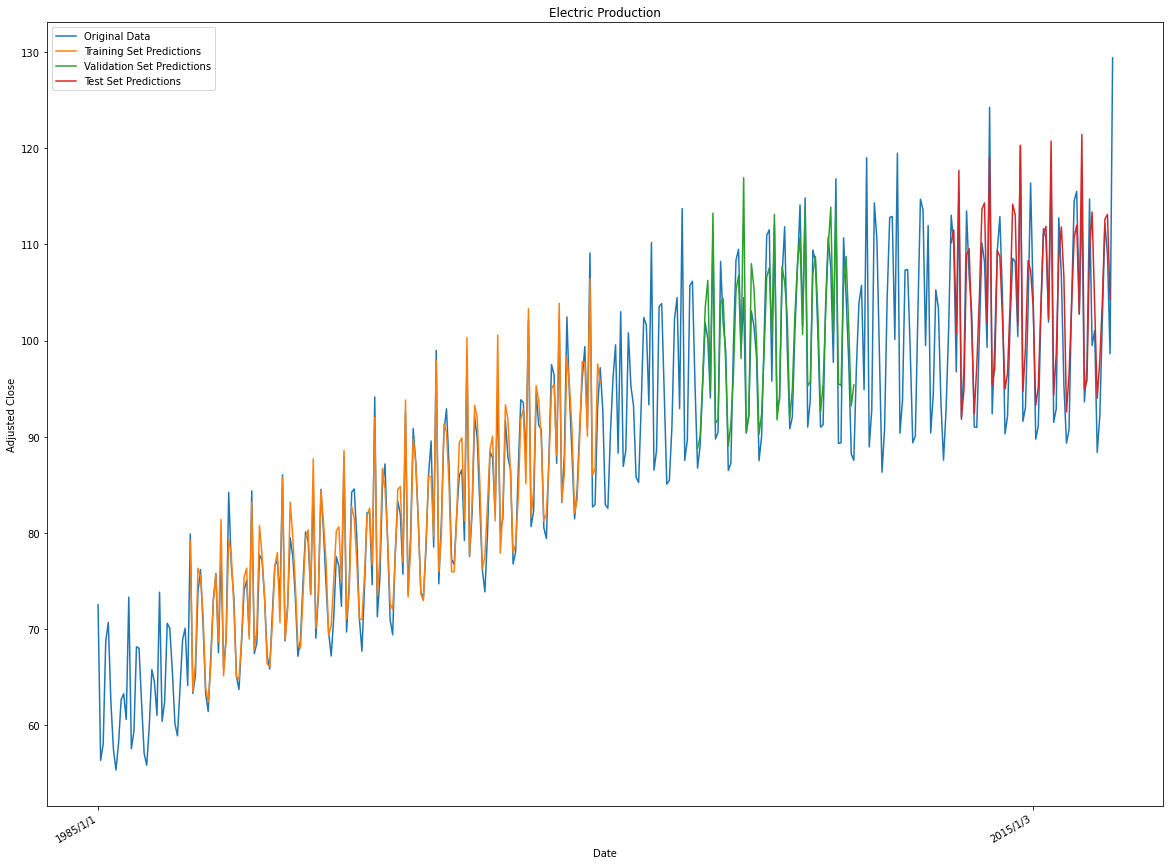

In [9]:
# Make predictions on all three sets
train_pred = model.predict(X_train)
validation_pred = model.predict(X_validation)
test_pred = model.predict(X_test)

print(r2_score(y_train, train_pred), " --> Training Set")
print(r2_score(y_validation, validation_pred), " --> Validation Set")
print(r2_score(y_test, test_pred), " --> Test Set")

# Un-scale the predictions
train_pred = scaler.inverse_transform(train_pred)
validation_pred = scaler.inverse_transform(validation_pred)
test_pred = scaler.inverse_transform(test_pred)

# Un-window the training predictions
plot_train_pred = np.empty((len(df_ep), 1))
plot_train_pred[:] = np.nan
plot_train_pred[window_size:len(train_pred) + window_size, :] = train_pred

# Un-window the validation predictions
plot_validation_pred = np.empty((len(df_ep), 1))
plot_validation_pred[:] = np.nan
plot_validation_pred[len(train_pred) + (window_size * 2) + 1:len(train_pred) + len(validation_pred) + (window_size * 2) + 1, :] = validation_pred

# Un-window the test predictions
plot_test_pred = np.empty((len(df_ep), 1))
plot_test_pred[:] = np.nan
plot_test_pred[len(train_pred) + len(validation_pred) + (window_size * 3) + 2:len(df_ep) - 1, :] = test_pred



### grafico

plt.figure(figsize=(20, 16))

# Plot the original data
plt.plot(df_ep, label="Original Data")

# Plot the predictions
plt.plot(plot_train_pred, label="Training Set Predictions")
plt.plot(plot_validation_pred, label="Validation Set Predictions")
plt.plot(plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('Electric Production')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.ylabel('Adjusted Close')
plt.legend()
plt.show()

In [ ]:
diccionario